<a href="https://colab.research.google.com/github/DilukaB/DL-TimeX-Advanced-Deep-Learning-Models-for-Financial-Time-Series-Prediction/blob/main/DeepPrice_Advanced_Stock_%26_Crypto_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("numpy:", np.__version__, "pandas:", pd.__version__, "tensorflow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))



numpy: 2.0.2 pandas: 2.2.2 tensorflow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
# Synthetic dataset generator (run only if you don't have a CSV)
def generate_synthetic_timeseries(n=2000):
    rng = pd.date_range(start='2016-01-01', periods=n, freq='D')
    trend = np.linspace(0, 50, n)
    seasonal = 10 * np.sin(np.arange(n)/14.0) + 5 * np.sin(np.arange(n)/30.0)
    noise = np.random.normal(scale=2.0, size=n)
    close = 100 + trend + seasonal + noise
    high = close + np.random.uniform(0.5, 2.0, size=n)
    low = close - np.random.uniform(0.5, 2.0, size=n)
    open_ = close + np.random.uniform(-1.0, 1.0, size=n)
    volume = np.random.randint(100000, 500000, size=n)
    return pd.DataFrame({'Date': rng, 'Open': open_, 'High': high, 'Low': low, 'Close': close, 'Volume': volume})

# Use synthetic if you didn't upload a file
try:
    df
    print("Using uploaded dataset")
except NameError:
    df = generate_synthetic_timeseries(2500)
    print("Using synthetic demo dataset (no CSV provided).")

# preview
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
print(df.head())
print("shape:", df.shape)


Using uploaded dataset
        Date        Open        High         Low       Close  Volume  \
0 2016-01-01  100.074079  102.714617   99.425098  100.993428  484934   
1 2016-01-02   99.813331  102.151495   99.859958  100.623794  225223   
2 2016-01-03  102.105773  103.757845  102.239122  103.092197  175205   
3 2016-01-04  105.037633  106.665527  104.490190  105.731746  101082   
4 2016-01-05  102.232827  104.059557  101.222594  103.094847  258566   

   Return_1       SMA_5      SMA_10      EMA_10  Volatility_5  
0  0.000000  100.993428  100.993428  100.993428      0.000000  
1 -0.003660  100.808611  100.808611  100.926222      0.000000  
2  0.024531  101.569806  101.569806  101.320036      0.000000  
3  0.025604  102.610291  102.610291  102.122165      0.000000  
4 -0.024940  102.707202  102.707202  102.299016      0.021213  
shape: (2500, 11)


Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Return_1               float64
SMA_5                  float64
SMA_10                 float64
EMA_10                 float64
Volatility_5           float64
dtype: object

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Return_1', 'SMA_5', 'SMA_10', 'EMA_10', 'Volatility_5']


,count,mean,min,25%,50%,75%,max,std
Date,2500,2019-06-03 12:00:00,2016-01-01 00:00:00,2017-09-16 18:00:00,2019-06-03 12:00:00,2021-02-17 06:00:00,2022-11-04 00:00:00,NaN
Open,2500.0,125.227477,86.201509,112.650301,124.714818,137.864788,167.699118,16.52673
High,2500.0,126.47597,88.000865,113.962518,126.213569,139.031995,168.53426,16.511027
Low,2500.0,123.998251,85.093007,111.530936,123.571116,136.606527,166.043015,16.520799
Close,2500.0,125.235547,86.591043,112.803646,124.833519,137.687513,167.758108,16.505258
Volume,2500.0,296484.9532,100903.0,195037.25,293294.5,395500.0,499877.0,116625.123351
Return_1,2500.0,0.000459,-0.082201,-0.015096,0.000095,0.015976,0.084453,0.023334
SMA_5,2500.0,125.187296,88.301523,112.739456,124.828653,137.690592,165.246912,16.375904
SMA_10,2500.0,125.127467,88.363501,112.626684,124.692032,137.708502,164.451607,16.287193
EMA_10,2500.0,125.125254,88.909403,112.566981,124.634813,137.82486,163.74395,16.174343


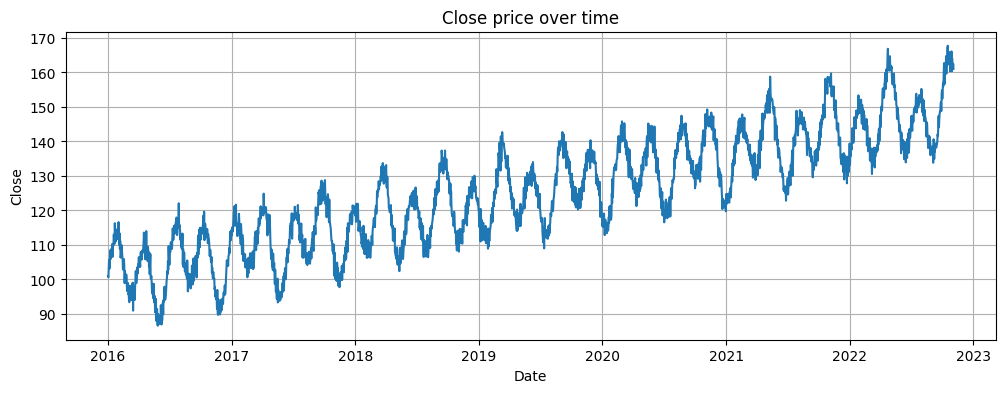

In [26]:
# ensure Date column parsed and sorted
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Show column names and types
print(df.dtypes)
print("\nColumns:", list(df.columns))

# Basic descriptive stats
display(df.describe().T)

# Plot Close price series
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Close'])
plt.title("Close price over time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.show()


In [27]:
# Keep main numeric columns (if your CSV uses different names, adjust)
expected_cols = ['Open','High','Low','Close','Volume']
for c in expected_cols:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' not found. Update column names or dataset.")

# Ensure numeric and handle missing values
for c in expected_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing numeric data
df = df.dropna(subset=expected_cols).reset_index(drop=True)

# Add indicators
df['Return_1'] = df['Close'].pct_change().fillna(0.0)
df['SMA_5'] = df['Close'].rolling(window=5, min_periods=1).mean()
df['SMA_10'] = df['Close'].rolling(window=10, min_periods=1).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['Volatility_5'] = df['Return_1'].rolling(5).std().fillna(0.0)

# Final feature list (you can add more)
features = ['Open','High','Low','Close','Volume','SMA_5','SMA_10','EMA_10','Return_1','Volatility_5']
TARGET_COL = 'Close'

# drop any remaining NA and reset
df = df.dropna().reset_index(drop=True)
print("Prepared dataset with features:", features)
print("Length:", len(df))
display(df.tail())


Prepared dataset with features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_10', 'EMA_10', 'Return_1', 'Volatility_5']
Length: 2500


,Date,Open,High,Low,Close,Volume,Return_1,SMA_5,SMA_10,EMA_10,Volatility_5
2495,2022-10-31,163.446628,165.054855,163.135936,164.083612,101607,0.023249,163.112008,163.209900,163.199156,0.024057
2496,2022-11-01,160.471927,163.380920,159.986825,161.443964,250595,-0.016087,162.913454,162.996986,162.880030,0.024892
2497,2022-11-02,161.489071,161.495595,160.013232,160.945460,148447,-0.003088,162.589818,162.665506,162.528290,0.024883
2498,2022-11-03,163.299947,163.919567,161.695866,162.549878,149757,0.009969,161.875669,162.485505,162.532215,0.022513
2499,2022-11-04,161.305614,161.827044,159.481517,161.077289,360114,-0.009059,162.020041,162.557965,162.267683,0.015695


In [28]:
# Chronological split (no shuffling) to avoid leakage
TEST_SIZE = 0.15
VAL_SIZE = 0.15

n = len(df)
test_n = int(n * TEST_SIZE)
val_n = int(n * VAL_SIZE)
train_n = n - test_n - val_n

train_df = df.iloc[:train_n].reset_index(drop=True)
val_df   = df.iloc[train_n:train_n+val_n].reset_index(drop=True)
test_df  = df.iloc[train_n+val_n:].reset_index(drop=True)

print("Sizes -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))


Sizes -> train: 1750 val: 375 test: 375


In [29]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Prepare arrays
X_train_raw = train_df[features].values
X_val_raw   = val_df[features].values
X_test_raw  = test_df[features].values

y_train_raw = train_df[[TARGET_COL]].values
y_val_raw   = val_df[[TARGET_COL]].values
y_test_raw  = test_df[[TARGET_COL]].values

# fit scaler on train only
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

print("Scaled shapes:", X_train.shape, y_train.shape)


Scaled shapes: (1750, 10) (1750, 1)


In [30]:
def make_windows(X, y, lookback=60, horizon=1, stride=1):
    # X: (n_samples, n_features), y: (n_samples,1)
    Xs, ys = [], []
    for i in range(0, len(X) - lookback - horizon + 1, stride):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback:i+lookback+horizon])
    return np.array(Xs), np.array(ys)

LOOKBACK = 60   # number of past days used for prediction
HORIZON  = 1    # predict next day's Close
STRIDE   = 1

Xtr, ytr = make_windows(X_train, y_train, LOOKBACK, HORIZON, STRIDE)
Xv, yv   = make_windows(X_val,   y_val,   LOOKBACK, HORIZON, STRIDE)
Xte, yte = make_windows(X_test,  y_test,  LOOKBACK, HORIZON, STRIDE)

print("Windowed shapes -> Xtr:", Xtr.shape, "ytr:", ytr.shape)


Windowed shapes -> Xtr: (1690, 60, 10) ytr: (1690, 1, 1)


In [31]:
def inverse_transform_y(y_scaled):
    # y_scaled can be shape (n,1) or (n, h, 1)
    orig_shape = y_scaled.shape
    flat = y_scaled.reshape(-1, 1)
    inv = scaler_y.inverse_transform(flat)
    return inv.reshape(orig_shape)
def evaluate_predictions(y_true_scaled, y_pred_scaled):
    y_true = inverse_transform_y(y_true_scaled).reshape(-1)
    y_pred = inverse_transform_y(y_pred_scaled).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    # old sklearn doesn't support squared=False → compute RMSE manually
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = (np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape, "R2": r2}


def plot_actual_vs_pred(y_true_scaled, y_pred_scaled, title='Pred vs Actual'):
    y_true = inverse_transform_y(y_true_scaled).reshape(-1)
    y_pred = inverse_transform_y(y_pred_scaled).reshape(-1)
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()


In [32]:
def build_lstm(input_shape):
    i = keras.Input(shape=input_shape)
    x = layers.LSTM(128, return_sequences=True)(i)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    o = layers.Dense(HORIZON, activation='linear')(x)  # HORIZON outputs (here 1)
    model = keras.Model(i, o, name='LSTM')
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

def build_gru(input_shape):
    i = keras.Input(shape=input_shape)
    x = layers.GRU(128, return_sequences=True)(i)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(64)(x)
    x = layers.Dropout(0.2)(x)
    o = layers.Dense(HORIZON, activation='linear')(x)
    model = keras.Model(i, o, name='GRU')
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

def build_bilstm(input_shape):
    i = keras.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(i)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.2)(x)
    o = layers.Dense(HORIZON, activation='linear')(x)
    model = keras.Model(i, o, name='BiLSTM')
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

# Small Transformer encoder stack for time series
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        pos = np.arange(maxlen)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2*(i//2))/np.float32(d_model))
        angle_rads = pos * angle_rates
        pe = np.zeros((maxlen, d_model))
        pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pe = tf.constant(pe[None, ...], dtype=tf.float32)
    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

def build_transformer(input_shape, d_model=64, num_heads=4, ff_dim=128, num_layers=2):
    i = keras.Input(shape=input_shape)
    x = layers.Dense(d_model)(i)
    x = PositionalEncoding(maxlen=input_shape[0], d_model=d_model)(x)
    for _ in range(num_layers):
        # multi-head attention block
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn = layers.Dropout(0.1)(attn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
        # feed-forward
        ff = layers.Dense(ff_dim, activation='relu')(x)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(0.1)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    o = layers.Dense(HORIZON, activation='linear')(x)
    model = keras.Model(i, o, name='Transformer')
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

# Model input shape: (LOOKBACK, n_features)
INPUT_SHAPE = (LOOKBACK, Xtr.shape[-1])
print("Input shape:", INPUT_SHAPE)


Input shape: (60, 10)


In [33]:
EPOCHS = 30
BATCH_SIZE = 64
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

models = {
    'LSTM': build_lstm(INPUT_SHAPE),
    'GRU': build_gru(INPUT_SHAPE),
    'BiLSTM': build_bilstm(INPUT_SHAPE),
    'Transformer': build_transformer(INPUT_SHAPE, d_model=64, num_heads=4, ff_dim=128, num_layers=2)
}

histories = {}
for name, model in models.items():
    print("\n== Training:", name)
    # ytr/yv are shaped (n_samples, HORIZON, 1) from windowing earlier. Our model expects (n_samples, HORIZON) as output.
    ytr_flat = ytr.reshape((ytr.shape[0], HORIZON))
    yv_flat  = yv.reshape((yv.shape[0], HORIZON))
    h = model.fit(
        Xtr, ytr_flat,
        validation_data=(Xv, yv_flat),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    histories[name] = h.history



== Training: LSTM
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0906 - val_loss: 0.0255
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0110 - val_loss: 0.0053
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0058
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11

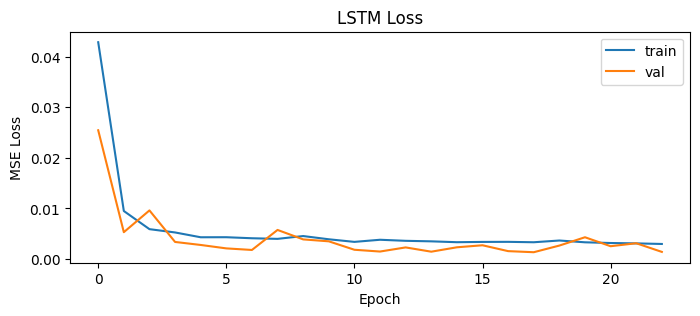

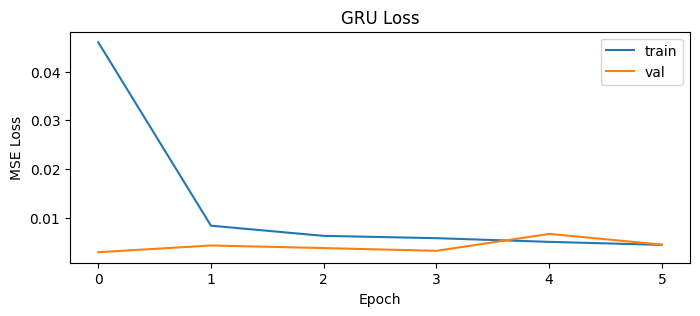

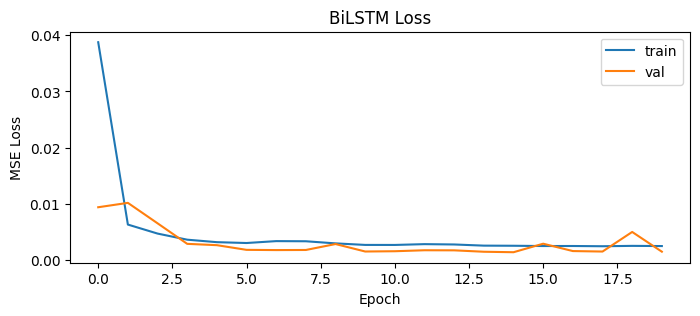

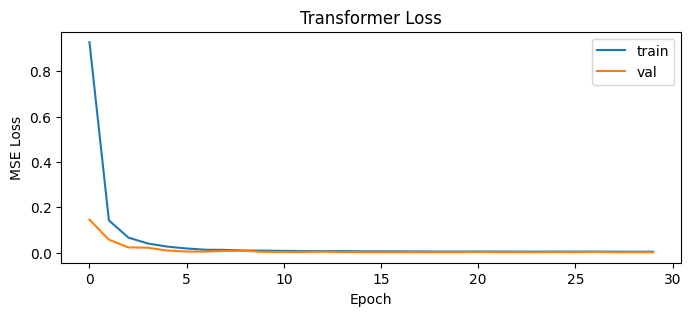

In [34]:
import matplotlib.pyplot as plt
for name, hist in histories.items():
    plt.figure(figsize=(8,3))
    plt.plot(hist['loss'], label='train')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='val')
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()


In [35]:
results = []
preds = {}

for name, model in models.items():
    # predict
    pred_scaled = model.predict(Xte)  # shape (n_samples, HORIZON)
    # reshape to (n, h, 1) to match evaluate_helpers
    pred_scaled3 = pred_scaled.reshape(pred_scaled.shape[0], HORIZON, 1)
    metrics = evaluate_predictions(yte, pred_scaled3)
    results.append({'Model': name, **metrics})
    preds[name] = pred_scaled3
    print(name, metrics)

results_df = pd.DataFrame(results).sort_values('RMSE')
display(results_df)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM {'MAE': 1.91717652088496, 'RMSE': np.float64(2.372965657660058), 'MAPE%': np.float64(1.2976777320186414), 'R2': 0.9293532855164961}
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
GRU {'MAE': 3.09951466610166, 'RMSE': np.float64(3.784692098099142), 'MAPE%': np.float64(2.07329818947916), 'R2': 0.8202908582516999}
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
BiLSTM {'MAE': 1.7987188396180367, 'RMSE': np.float64(2.273345957566986), 'MAPE%': np.float64(1.226489483285109), 'R2': 0.9351604299328452}
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
Transformer {'MAE': 1.9647863628961526, 'RMSE': np.float64(2.3938976961940828), 'MAPE%': np.float64(1.3331518778443423), 'R2': 0.9281014326403616}


,Model,MAE,RMSE,MAPE%,R2
2,BiLSTM,1.798719,2.273346,1.226489,0.935160
0,LSTM,1.917177,2.372966,1.297678,0.929353
3,Transformer,1.964786,2.393898,1.333152,0.928101
1,GRU,3.099515,3.784692,2.073298,0.820291


Best model: BiLSTM


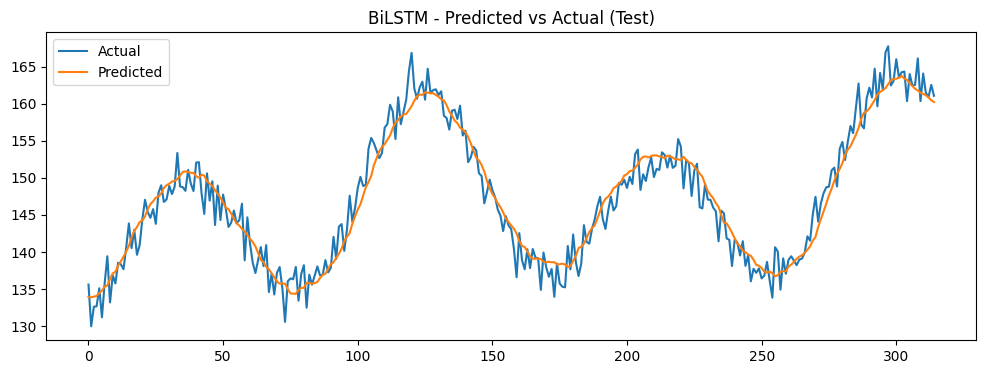

In [36]:
best = results_df.iloc[0]['Model']
print("Best model:", best)
plot_actual_vs_pred(yte, preds[best], title=f"{best} - Predicted vs Actual (Test)")


In [37]:
os.makedirs('artifacts', exist_ok=True)
results_df.to_csv('artifacts/model_comparison.csv', index=False)
for name, model in models.items():
    model.save(f'artifacts/{name}.keras')
print("Saved artifacts:", os.listdir('artifacts'))


Saved artifacts: ['model_comparison.csv', 'BiLSTM.keras', 'LSTM.keras', 'Transformer.keras', 'GRU.keras']
